In [1]:
!pip install --pre deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 19.5 MB/s eta 0:00:00


In [2]:
import deepchem as dc
dc.__version__

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.8.1.dev'

In [3]:
import numpy as np

In [4]:
import tensorflow as tf

In [6]:
n_classes = 4
class_centers = np.random.uniform(-4, 4, (n_classes, 2))
class_transforms = []

for i in range(n_classes):
  x_scale = np.random.uniform(0.5,2)
  y_scale = np.random.uniform(0.5, 2)
  angle = np.random.uniform(0, np.pi)

  m = [[x_scale*np.cos(angle), -y_scale*np.sin(angle)],
       [x_scale*np.sin(angle), y_scale*np.cos(angle)]]

  class_transforms.append(m)
class_transforms = np.array(class_transforms)

In [17]:
def generate_data(n_points):
  classes = np.random.randint(n_classes, size=n_points)
  r = np.random.random(n_points)
  angle = 2*np.pi*np.random.random(n_points)
  points = (r*np.array([np.cos(angle), np.sin(angle)])).T
  points = np.einsum('ijk,ik->ij', class_transforms[classes], points)
  points += class_centers[classes]
  return classes, points

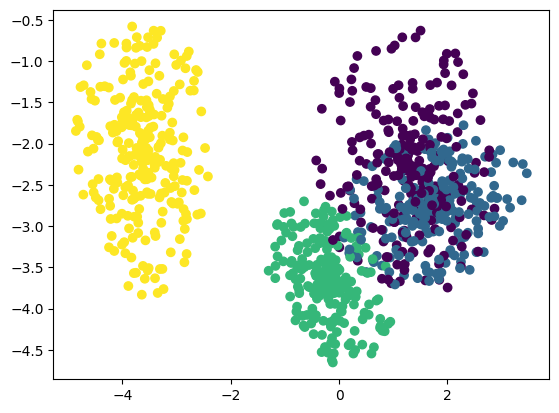

In [47]:
import matplotlib.pyplot as plot
%matplotlib inline

classes, points = generate_data(1000)
plot.scatter(x=points[:,0], y=points[:,1], c=classes)

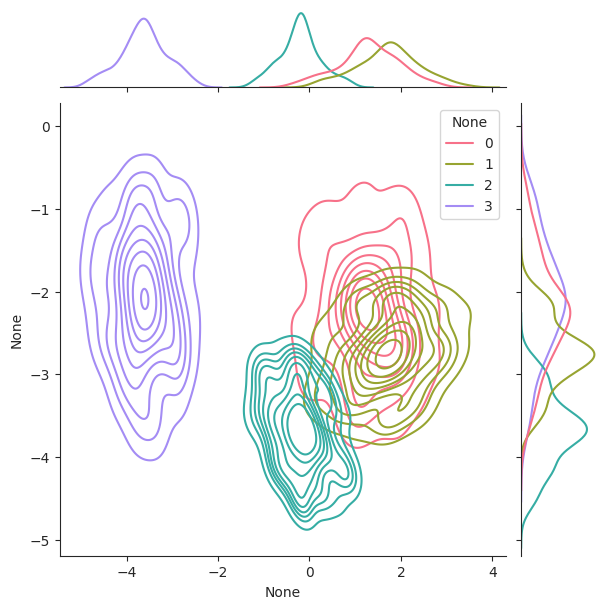

In [64]:
import seaborn as sns
sns.set_style('ticks')
pal = sns.color_palette("husl",4)
fig = sns.jointplot(x=points[:,0], y=points[:,1], hue=classes, palette=pal, kind="kde")

In [67]:
from tensorflow.keras.layers import Concatenate, Dense, Input

class ExampleGAN(dc.models.GAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(2,)]

  def get_conditional_input_shapes(self):
    return [(n_classes,)]

  def create_generator(self):
    noise_in = Input(shape=(10,))
    conditional_in = Input(shape=(n_classes,))
    get_in = Concatenate()([noise_in, conditional_in])
    get_dense1 = Dense(30, activation=tf.nn.relu)(get_in)
    get_dense2 = Dense(30, activation=tf.nn.relu)(get_dense1)
    generator_points = Dense(2)(get_dense2)
    return tf.keras.Model(inputs=[noise_in, conditional_in], outputs=[generator_points])

  def create_discriminator(self):
    data_in = Input(shape=(2,))
    conditional_in = Input(shape=(n_classes,))
    discrim_in = Concatenate()([data_in, conditional_in])
    discrim_dense1 = Dense(30, activation=tf.nn.relu)(discrim_in)
    discrim_dense2 = Dense(30, activation=tf.nn.relu)(discrim_dense1)
    discrim_prob = Dense(1, activation=tf.sigmoid)(discrim_dense2)
    return tf.keras.Model(inputs=[data_in, conditional_in], outputs=[discrim_prob])

In [68]:
gan = ExampleGAN(learning_rate=1e-4)

In [69]:
def iterbatches(batches):
  for i in range(batches):
    classes, points = generate_data(gan.batch_size)
    classes = dc.metrics.to_one_hot(classes, n_classes)
    yield {gan.data_inputs[0]: points, gan.conditional_inputs[0]: classes}

gan.fit_gan(iterbatches(5000))

Ending global_step 999: generator average loss 0.889474, discriminator average loss 1.16544
Ending global_step 1999: generator average loss 0.757303, discriminator average loss 1.33801
Ending global_step 2999: generator average loss 0.695866, discriminator average loss 1.38358
Ending global_step 3999: generator average loss 0.698111, discriminator average loss 1.38273
Ending global_step 4999: generator average loss 0.696694, discriminator average loss 1.38412
TIMING: model fitting took 109.272 s


In [76]:
classes, points = generate_data(1000)
one_hot_classes = dc.metrics.to_one_hot(classes, n_classes)
gen_points = gan.predict_gan_generator(conditional_inputs=[one_hot_classes])

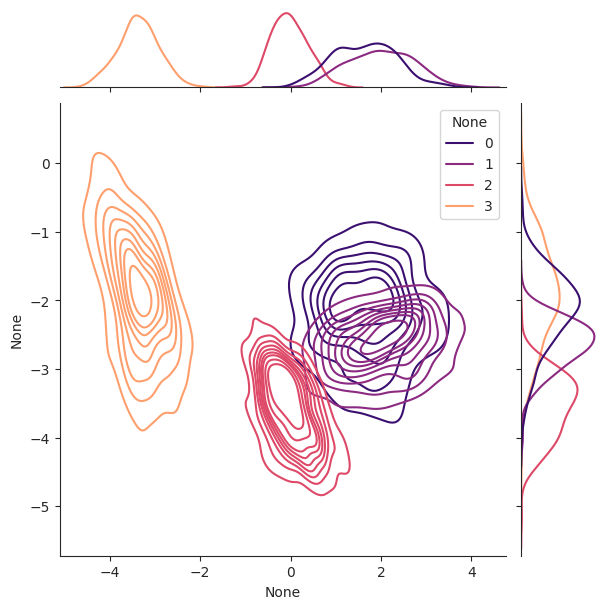

In [77]:
pal2 = sns.color_palette("magma",4)
fig = sns.jointplot(x=gen_points[:,0], y=gen_points[:,1], hue=classes, palette=pal2, kind="kde")